In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from pypoman import plot_polygon
import sys
from pip import main
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# hybrid a star
hybrid_path_plan = os.path.abspath(
    "../path_planner/"
)
utils_path = os.path.abspath(
    "../path_planner/utils/"
)

sys.path.append(hybrid_path_plan)
sys.path.append(utils_path)

# obca
obca_path = os.path.abspath(
    "../obca_py/"
)
sys.path.append(obca_path)

In [3]:
import map_utils
from orchard_geometry_environment import OrchardGeometryEnvironment
from OGE_OBCA import orchard_environment_OBCA
from utils.cubic_spline import calc_spline_course

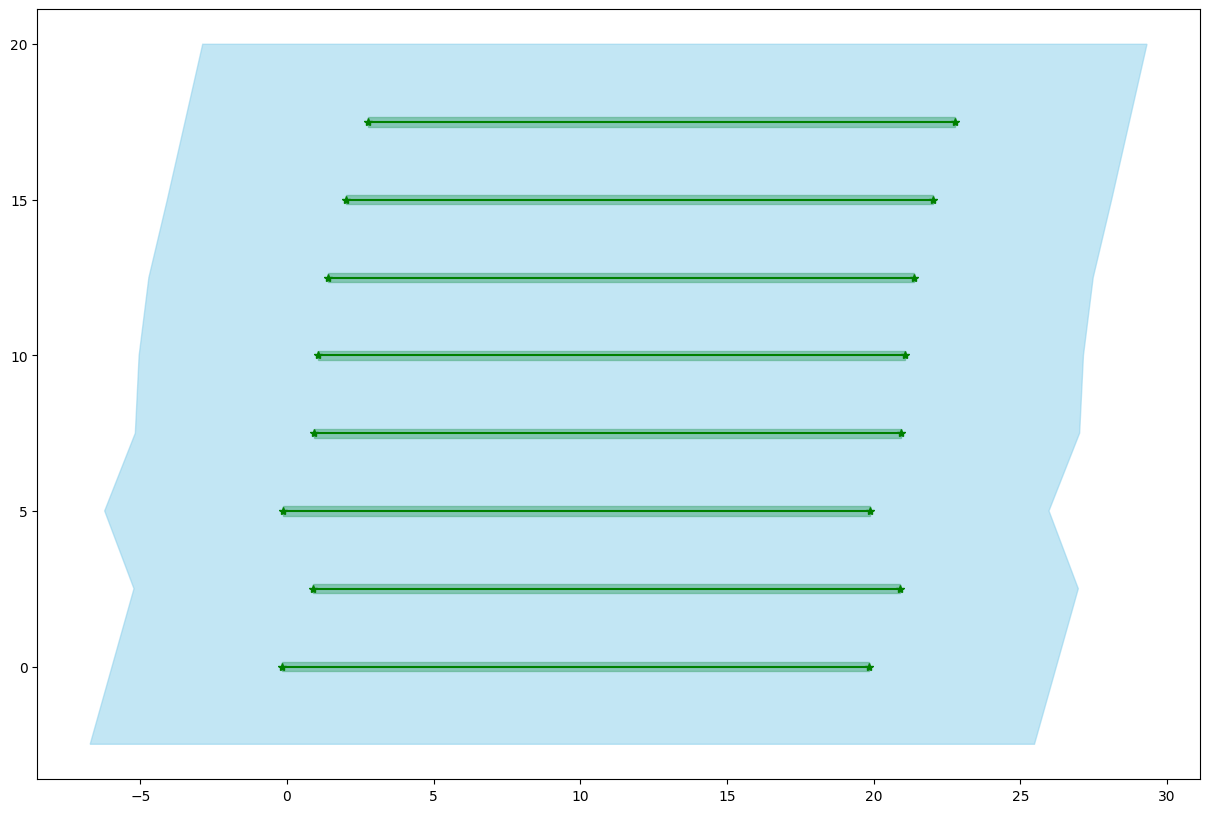

In [4]:
plt.rcParams["figure.figsize"] = [15, 10]

row_width = 2.5
tree_width = 0.3
row_num = 8
row_length = 20
headland_width = 6.0

np.random.seed(1)
tree_rows = map_utils.create_tree_rows(
    row_num, row_width, row_length, slope_angle=m.radians(10), l_std=1.0
)
map_env = orchard_environment_OBCA(
    tree_rows, [], tree_width=tree_width, headland_width=headland_width
)
map_env.plot_field_geometry(plt)
# map_env.contour_points

Text(0.1, 0.5, 'y')

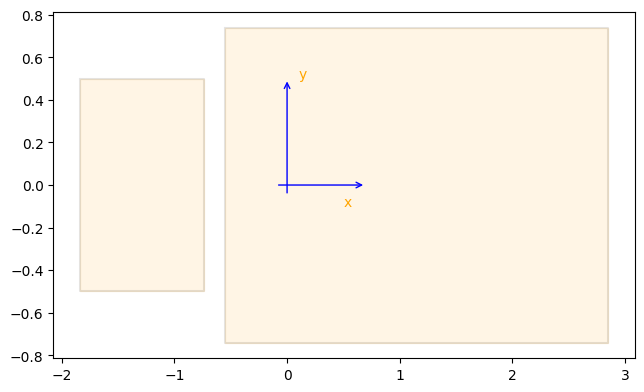

In [5]:
plt.rcParams["figure.figsize"] = [7.5, 4.5]
from car_model import CarModel

# mowing
aux_poly_features = [[[-1.84, 0.5], 1.0, 1.1]]

# summer pruning
# aux_poly_features = [[[2.69,-0.299],0.38,0.804],[[3.259,-0.175],1.325,0.3]]
# aux_poly_features = [[[3.259,-0.175],1.325,0.3]]

# KMS sprayer
# aux_poly_features = [[[-2.1,1.0/2],1.0,1.22],[[-1.0,4.3/2],0.4,0.5],[[-1.0,-4.3/2+0.4],0.4,0.5]]


car_with_operator = CarModel(
    max_steer=0.55,
    axle_to_back=0.55,
    width=1.48,
    aux_poly_features=aux_poly_features,
    with_aux=True,
)
empty_car = CarModel(max_steer=0.55, axle_to_back=0.55, width=1.48, with_aux=False)
car_poly, auxs = car_with_operator.draw_car(plt, 0, 0, 0)
plt.annotate(
    "", xy=(-0.1, 0), xytext=(0.7, 0), arrowprops=dict(arrowstyle="<-", color="blue")
)
plt.annotate(
    "", xy=(0, -0.05), xytext=(0, 0.5), arrowprops=dict(arrowstyle="<-", color="blue")
)
plt.text(0.5, -0.1, "x", c="orange")
plt.text(0.1, 0.5, "y", c="orange")

### Base pose
- These poses depends on the operation types

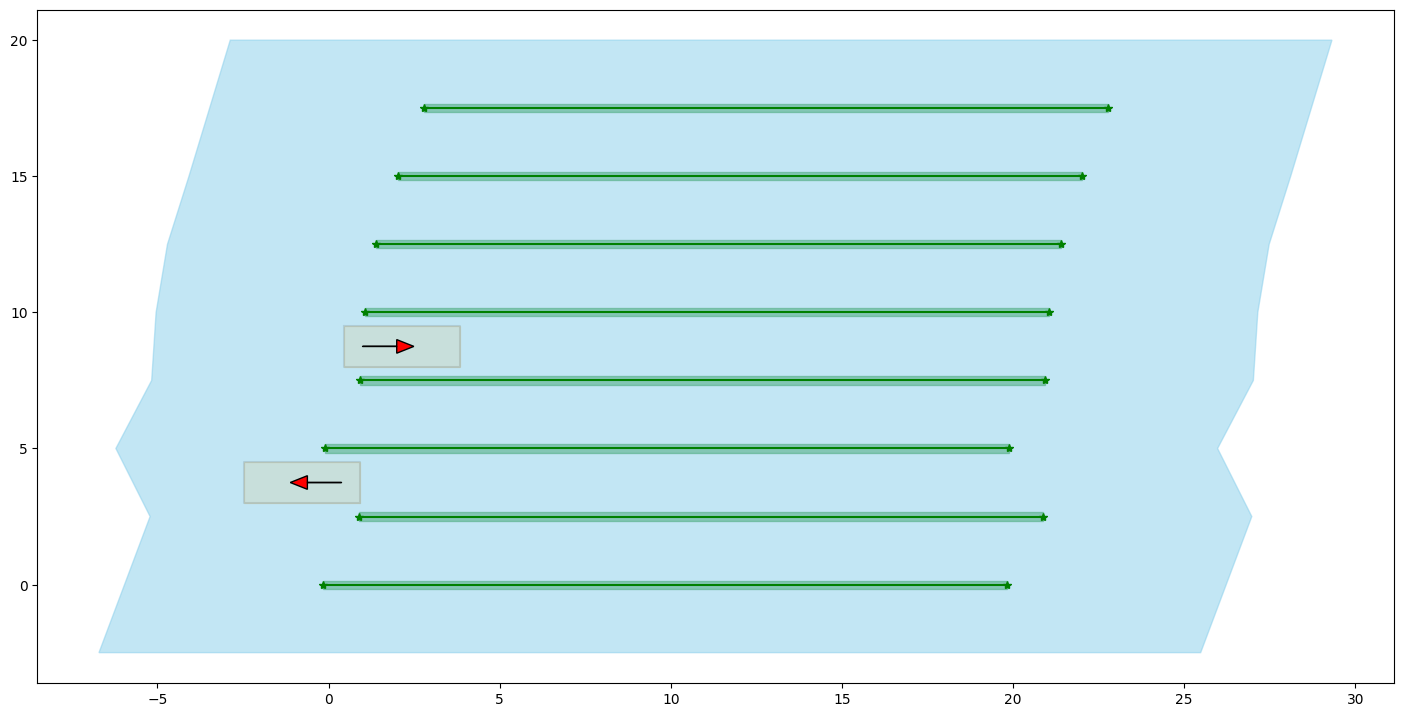

In [6]:
plt.rcParams['figure.figsize'] = [35/2, 17.5/2]
from map_utils import plot_arrow
start_row_id = 1
end_row_id = 3
side = map_utils.NEAR_SIDE
start_exit_pose  = map_utils.get_base_pose(start_row_id, tree_rows, -0.0, side=side, pose_type=map_utils.LEAVE_POSE)
end_enter_pose  = map_utils.get_base_pose(end_row_id, tree_rows, 0, side=side, pose_type=map_utils.ENTER_POSE)
map_env.plot_field_geometry(plt)
empty_car.draw_car(plt, start_exit_pose[0],start_exit_pose[1],start_exit_pose[2])
empty_car.draw_car(plt, end_enter_pose[0],end_enter_pose[1],end_enter_pose[2])

plot_arrow(start_exit_pose[0],start_exit_pose[1],start_exit_pose[2],plt)
plot_arrow(end_enter_pose[0],end_enter_pose[1],end_enter_pose[2],plt)

### Case I: forward only

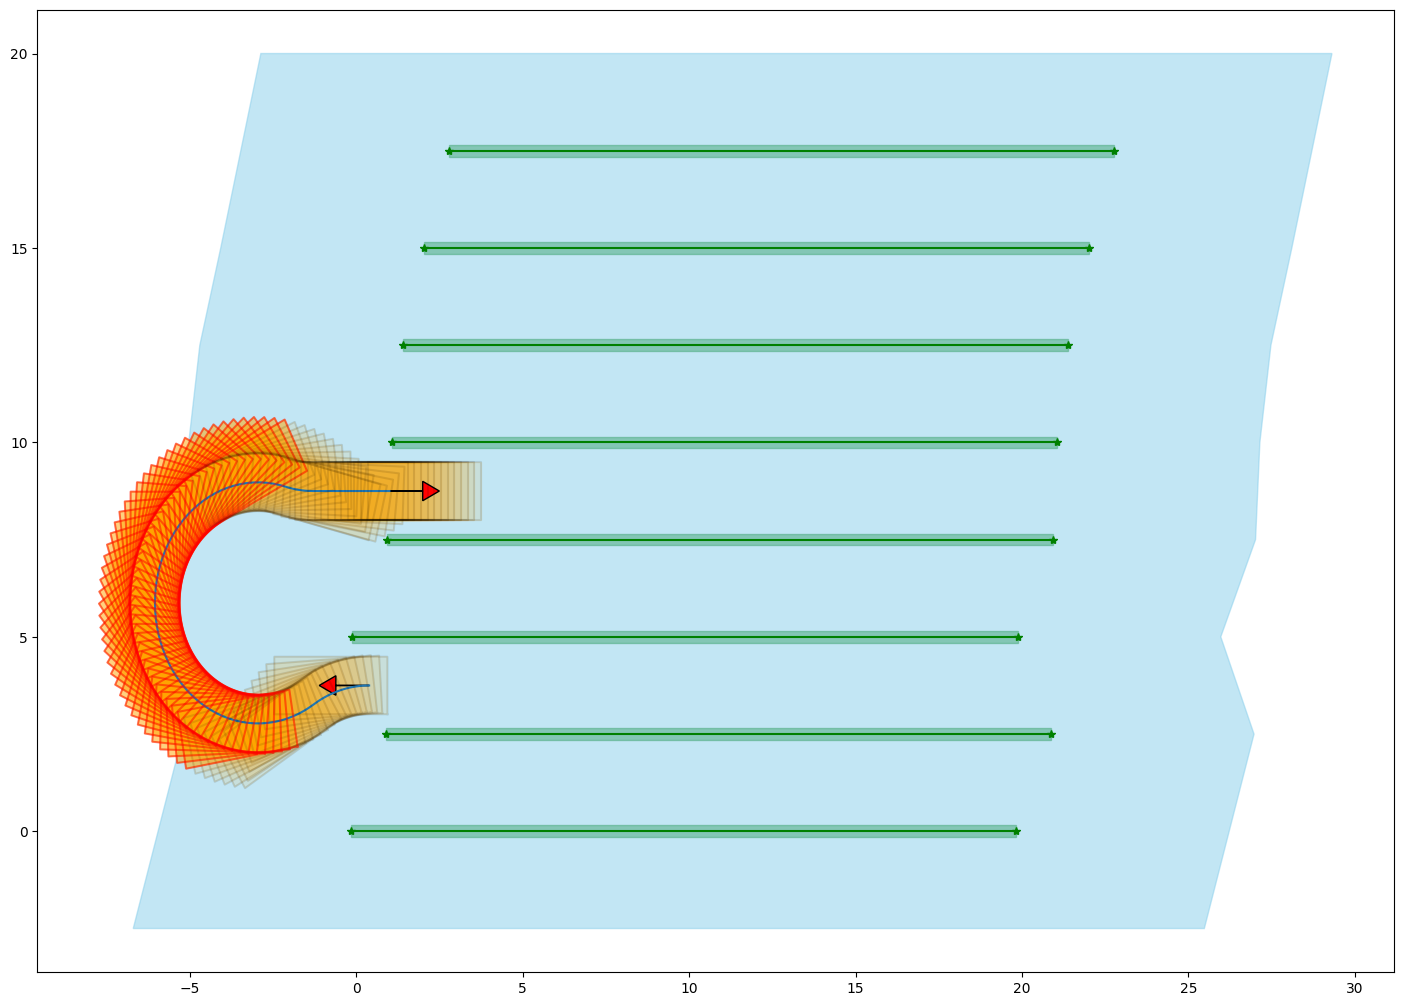

In [7]:
from safety_forward_path_plan import get_start_end_pose_for_dubins, get_dubins_path_full
plt.rcParams['figure.figsize'] = [35/2, 25/2]

safe_start_pose, safe_end_pose, leave_offset, enter_offset = get_start_end_pose_for_dubins(tree_rows,
    start_row_id,
    end_row_id,
    car_with_operator,
    map_env,
    max_steer_angle=0.55,
    plt=None,
    side=side,
    extra_offset_enter_dist=0.0,  # outer direction of the row entering
    extra_offset_leave_dist=0.0,  # outer direction of the row leaving
)

path = get_dubins_path_full(safe_start_pose, safe_end_pose, 1./car_with_operator.curvature) 
if leave_offset > 0.1:
    leave_path = get_dubins_path_full(start_exit_pose, safe_start_pose, 1./car_with_operator.curvature)
    path = np.vstack([leave_path, path]) 
if enter_offset > 0.1:
    enter_path = get_dubins_path_full(safe_end_pose, end_enter_pose,1./car_with_operator.curvature)
    path = np.vstack([path, enter_path]) 


map_env.plot_field_geometry(plt)
# car_with_operator.draw_car(plt, start_exit_pose[0],start_exit_pose[1],start_exit_pose[2],color='red',alpha=0.5)
# car_with_operator.draw_car(plt, safe_start_pose[0],safe_start_pose[1],safe_start_pose[2])

# car_with_operator.draw_car(plt, end_enter_pose[0],end_enter_pose[1],end_enter_pose[2],color='red',alpha=0.5)
# car_with_operator.draw_car(plt, safe_end_pose[0],safe_end_pose[1],safe_end_pose[2])

plt.plot(path[:,0],path[:,1])
for x,y,yaw in zip(path[0:-1:2,0],path[0:-1:2,1],path[0:-1:2,2]):
    if not map_env.check_path_feasibility(empty_car, np.array([[x,y,yaw]])):
        empty_car.draw_car(plt, x, y, yaw, color='red', alpha=0.5)    
    else:
        empty_car.draw_car(plt, x, y, yaw)

plot_arrow(start_exit_pose[0],start_exit_pose[1],start_exit_pose[2],plt)
plot_arrow(end_enter_pose[0],end_enter_pose[1],end_enter_pose[2],plt)

### Case II: Fish-tail turn

(<POLYGON ((-1.858 9.49, -1.858 8.01, 1.542 8.01, 1.542 9.49, -1.858 9.49))>,
 [<POLYGON ((-3.148 9.25, -2.048 9.25, -2.048 8.25, -3.148 8.25, -3.148 9.25))>])

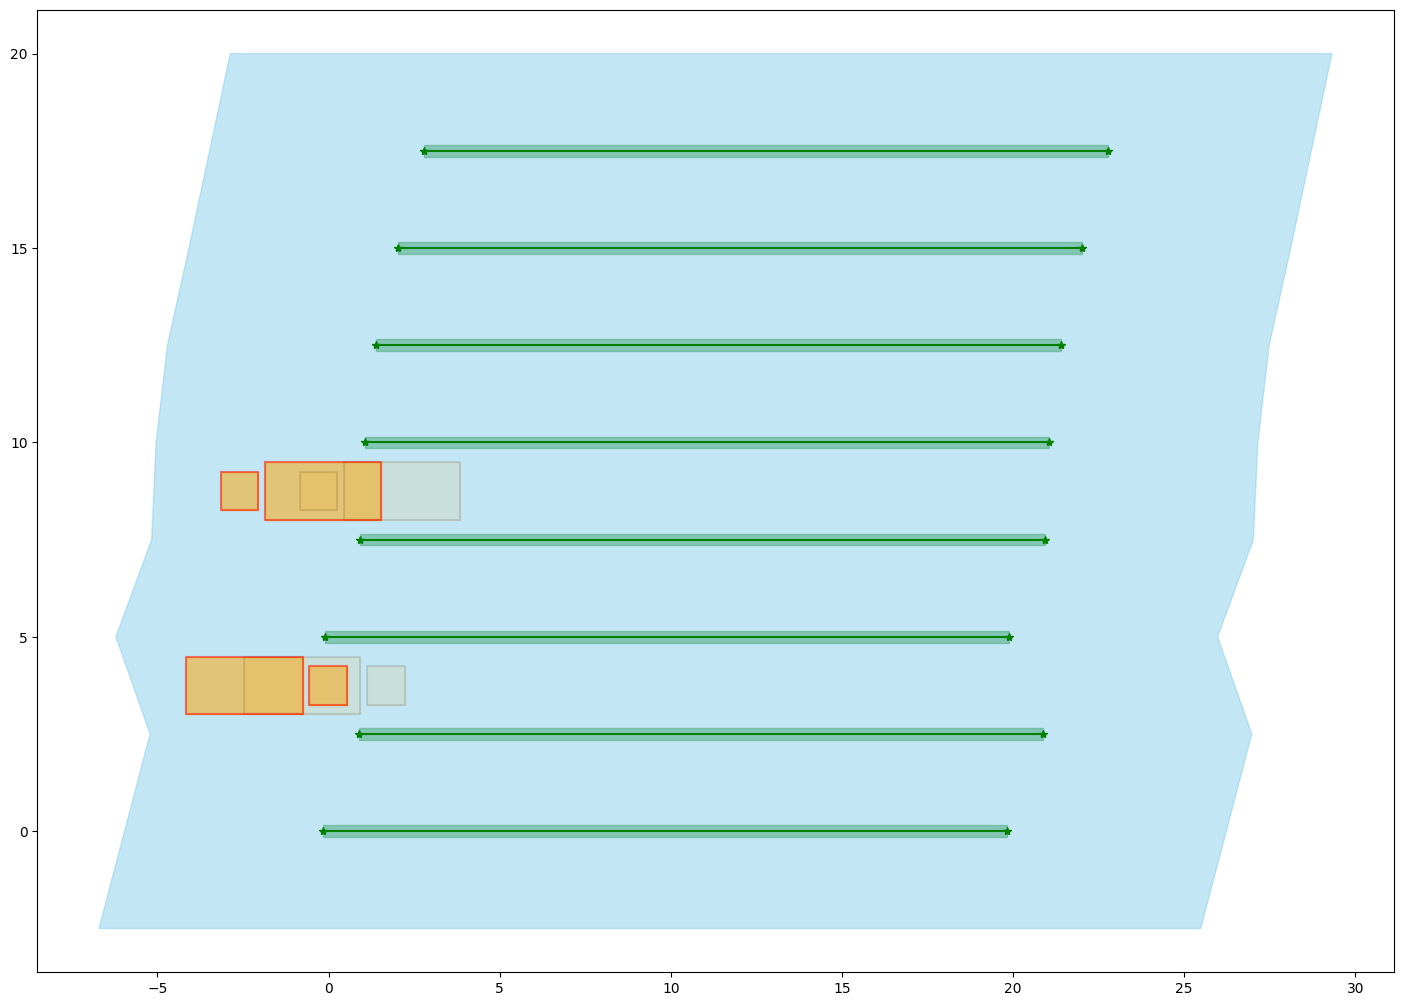

In [8]:
from safety_forward_path_plan import get_start_end_pose_for_reeds_shepp

(
    safe_start_pose,
    safe_end_pose,
    leave_offset,
    enter_offset,
) = get_start_end_pose_for_reeds_shepp(
    tree_rows,
    start_row_id,
    end_row_id,
    car_with_operator,
    map_env,
    max_steer_angle=0.55,
    plt=None,
    side=side,
    extra_offset_enter_dist=0.0,  # outer direction of the row entering
    extra_offset_leave_dist=0.0,  # outer direction of the row leaving
)

map_env.plot_field_geometry(plt)
car_with_operator.draw_car(
    plt, start_exit_pose[0], start_exit_pose[1], start_exit_pose[2]
)
car_with_operator.draw_car(
    plt,
    safe_start_pose[0],
    safe_start_pose[1],
    safe_start_pose[2],
    color="red",
    alpha=0.5,
)

car_with_operator.draw_car(plt, end_enter_pose[0], end_enter_pose[1], end_enter_pose[2])
car_with_operator.draw_car(
    plt, safe_end_pose[0], safe_end_pose[1], safe_end_pose[2], color="red", alpha=0.5
)

path type:  ['R', 'L', 'R']
path_is_feasible:  True
start_exit_pose:  [0.38166505 3.75       3.14159265]
safe_start_pose:  [-1.30805046  3.75        3.14159265]


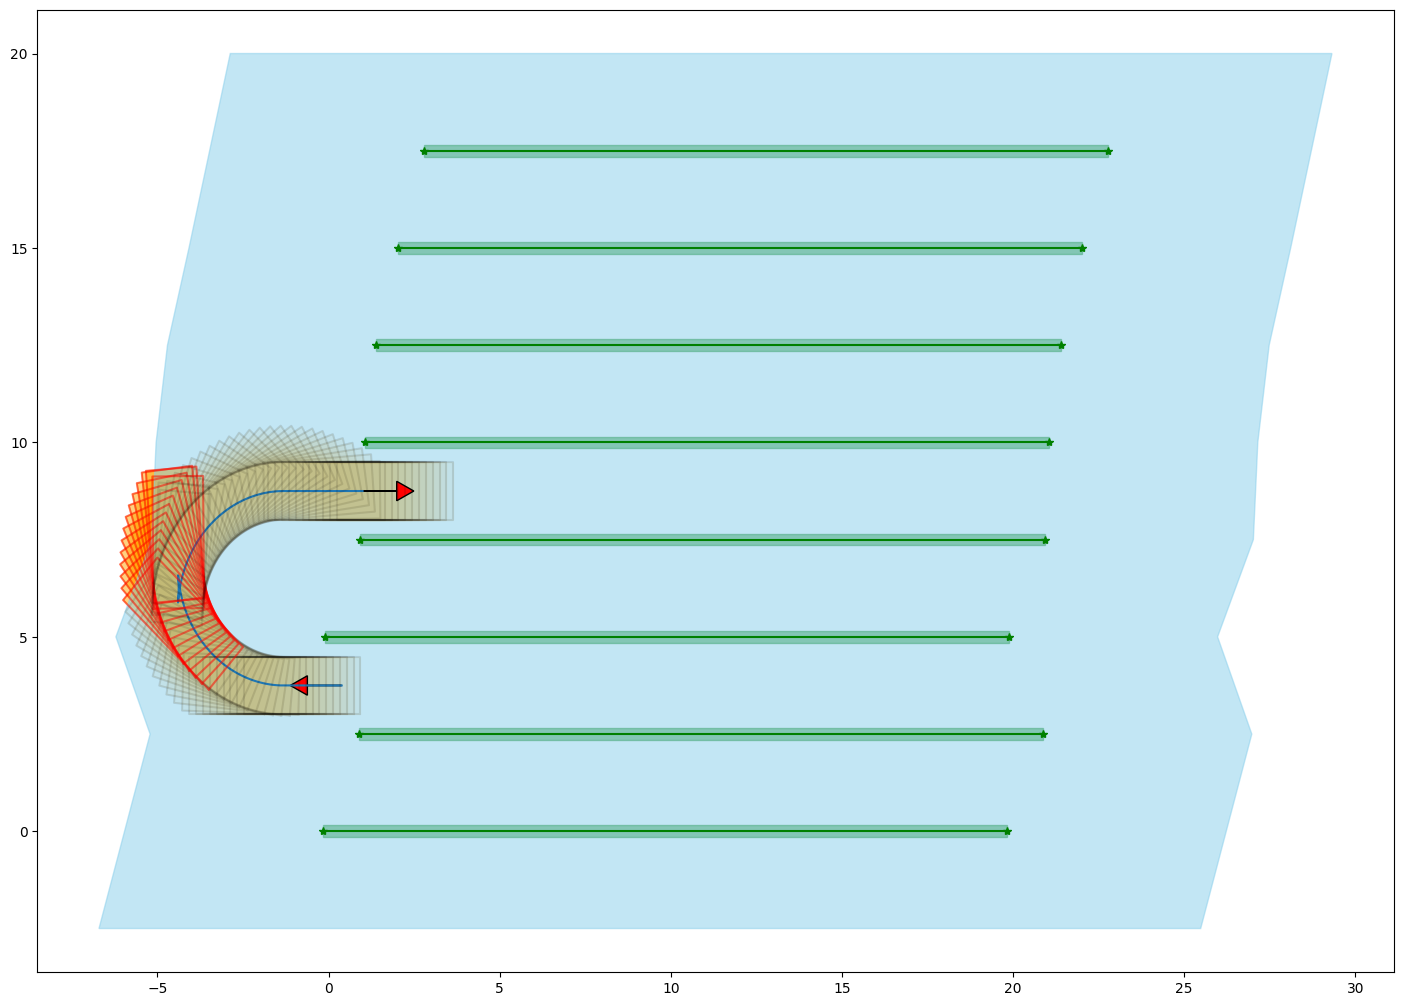

In [9]:
import utils.reeds_shepp as rs_curves

to_goal_paths = rs_curves.calc_all_paths(
    safe_start_pose[0],
    safe_start_pose[1],
    safe_start_pose[2],
    safe_end_pose[0],
    safe_end_pose[1],
    safe_end_pose[2],
    car_with_operator.curvature,
    0.1,
)

plt.rcParams["figure.figsize"] = [17.5, 12.5]
optimal_path = []
optimal_cost = 99999
for path in to_goal_paths:
    # plt.plot(path.x, path.y)
    traj = np.array([path.x, path.y, path.yaw]).T

    path_is_feasible = map_env.check_path_feasibility(
        empty_car, traj, boundary_check=False
    )
    if path_is_feasible:
        print("path type: ", path.ctypes)
        print("path_is_feasible: ", path_is_feasible)
        path_lengths = np.array(path.lengths)
        backward_lengths_idxs = np.where(path_lengths < 0)
        backward_lengths = path_lengths[backward_lengths_idxs]
        path_cost = np.abs(backward_lengths.sum())
        if path_cost < optimal_cost:
            optimal_path = path
            optimal_cost = path_cost
    # empty_car.draw_car(plt, traj[0,0],traj[0,1],traj[0,2],alpha=1,color='red')
    # empty_car.draw_car(plt, traj[-1,0],traj[-1,1],traj[-1,2],alpha=1,color='red')


# for x,y,yaw in zip(optimal_path.x,optimal_path.y,optimal_path.yaw):
#     car_with_operator.draw_car(plt, x, y, yaw)
# plt.plot(optimal_path.x, optimal_path.y)

path = np.array(
    [
        optimal_path.x,
        optimal_path.y,
        optimal_path.yaw,
        optimal_path.cs,
        optimal_path.directions,
    ]
).T
print("start_exit_pose: ", start_exit_pose)
print("safe_start_pose: ", safe_start_pose)

if leave_offset > 0.1:
    leave_path = get_dubins_path_full(
        start_exit_pose, safe_start_pose, 1.0 / car_with_operator.curvature
    )
    path = np.vstack([leave_path[:-1], path])
if enter_offset > 0.1:
    enter_path = get_dubins_path_full(
        safe_end_pose, end_enter_pose, 1.0 / car_with_operator.curvature
    )
    path = np.vstack([path, enter_path[1:]])

plt.plot(path[:, 0], path[:, 1])
for x, y, yaw in zip(path[0:-1:2, 0], path[0:-1:2, 1], path[0:-1:2, 2]):
    if not map_env.check_path_feasibility(empty_car, np.array([[x, y, yaw]])):
        empty_car.draw_car(plt, x, y, yaw, color="red", alpha=0.5)
    else:
        empty_car.draw_car(plt, x, y, yaw)
map_env.plot_field_geometry(plt)

plot_arrow(start_exit_pose[0], start_exit_pose[1], start_exit_pose[2], plt)
plot_arrow(end_enter_pose[0], end_enter_pose[1], end_enter_pose[2], plt)

In [10]:
from util import wrap_angle, process_angle, get_init_ref_path

desired_v = 0.5
dT = 0.2
ds = desired_v * dT
# ref_traj = np.vstack([path_xs, path_ys, dirs, path_yaws, path_ks]).T
# ref_traj[:, 2] = dirs * desired_v
# ref_traj[:, -1] = np.arctan(car.WHEEL_BASE * np.array(path_ks))
ref_traj = get_init_ref_path(
    empty_car,
    path[:, 0],
    path[:, 1],
    path[:, 2],
    path[:, 3],
    path[:, 4],
    desired_v=desired_v,
    ds=ds,
)

# ref_traj[:,3] = process_angle(ref_traj[:,3])
# plt.plot(ref_traj[:,3])
ref_traj[0]

array([ 0.38166505,  3.75      ,  0.        , -3.14159265,  0.        ])

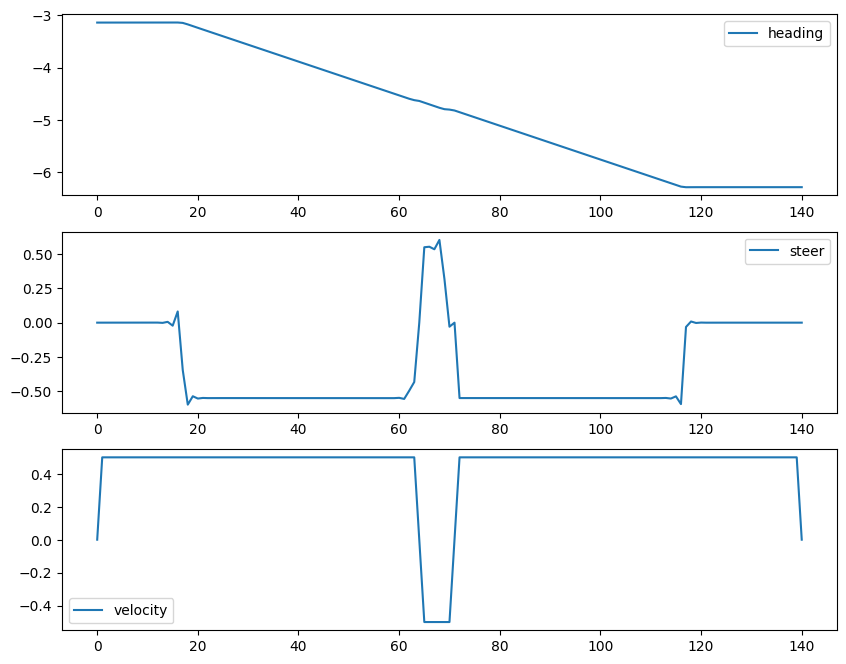

In [11]:
plt.rcParams["figure.figsize"] = [10, 8]

time_coarse = np.arange(0, dT * len(ref_traj), dT)
figure, axs = plt.subplots(3, 1)
axs[0].plot(ref_traj[:, 3], label="heading")
axs[0].legend()

axs[1].plot(ref_traj[:, -1], label="steer")
axs[1].legend()

axs[2].plot(ref_traj[:, 2], label="velocity")

axs[2].legend()

### Circle-back turning

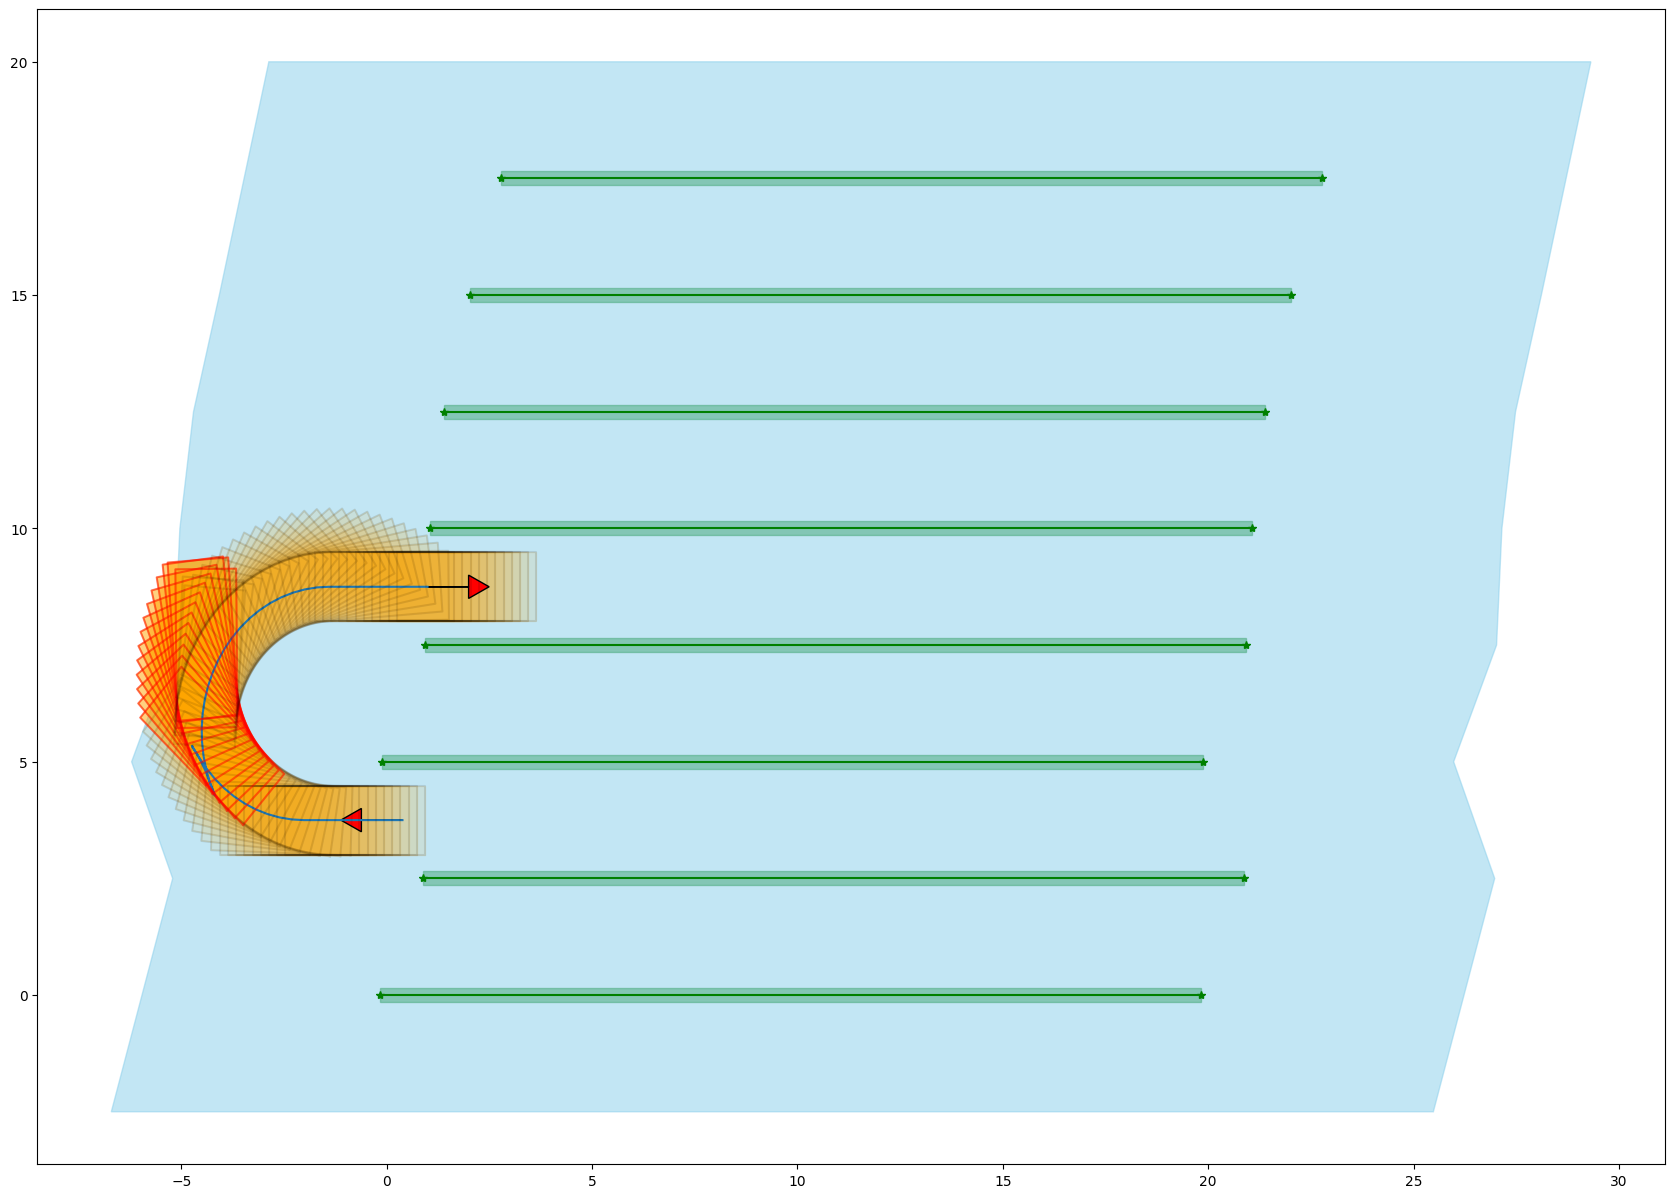

In [13]:
from safety_forward_path_plan import classic_circle_back_turning_path


plt.rcParams['figure.figsize'] = [21, 15]
map_env.plot_field_geometry(plt)

# get turning path from circle back turn
turning_path = classic_circle_back_turning_path(start_exit_pose, end_enter_pose, map_env, empty_car, step_size=0.3, plt=None)


plt.plot(turning_path[:,0],turning_path[:,1])
for x,y,yaw in zip(path[0:-1:2,0],path[0:-1:2,1],path[0:-1:2,2]):
    if not map_env.check_path_feasibility(empty_car, np.array([[x,y,yaw]])):
        empty_car.draw_car(plt, x, y, yaw, color='red', alpha=0.5)    
    else:
        empty_car.draw_car(plt, x, y, yaw)

plot_arrow(start_exit_pose[0],start_exit_pose[1],start_exit_pose[2],plt)
plot_arrow(end_enter_pose[0],end_enter_pose[1],end_enter_pose[2],plt)


